# §1.1 多項式曲線フィッティング

In [92]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

$\mathrm{sin}(2\pi x)$ に従うデータにガウス分布に従う小さなランダムノイズを加えて対応する訓練データを作る。ここでは標準正規分布に従う乱数を小さくしたものをのっける。

In [2]:
x = np.linspace(0, 1, 200)

# 訓練データ
np.random.seed(123)
x_data = np.linspace(0, 1, 11)
noise = np.random.randn(11)/5
y_data = np.sin(2*np.pi*x_data) + noise

多項式フィッテイングを行う。Pythonを用いる場合はいくつかの手法が考えられ：

- curve_fit
- numpy.polyfit : 最小二乗法を用いた polynomial fitting

求めたい目的とする多項式の関数形は $x$ に対しては非線形であるが（高次の項を含んでいる）、未知のパラメーターについては線形である。それゆえ「線形モデル」と呼ばれる。

まず初めに、non-linear least squaresを最小化する `curve_fit` を使用する。このメソッドはsum-of-squared error (二乗和誤差)を最小化する（=各係数についての微分連立方程式を解く）。

$$
E(w) = \frac{1}{2} \sum_{n=1}^{N} \{ y(x_n, w) - t_n \}^2
$$

In [3]:
from scipy.optimize import curve_fit

def func_m1(x, a, b):
    return a*x + b

def func_m3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

popt_m1, pcov_m1 = curve_fit(func_m1, x_data, y_data)
popt_m3, pcov_m3 = curve_fit(func_m3, x_data, y_data)
# popt : フィット後のパラメーター
# pcov : poptの共分散

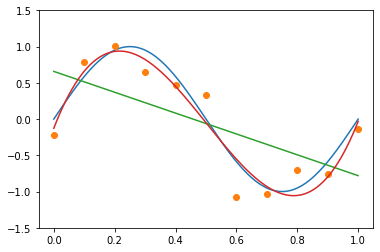

In [4]:
plt.ylim(-1.5, 1.5)

plt.plot(x, np.sin(2*np.pi*x))
plt.plot(x_data, y_data, marker='o', linewidth=0)
plt.plot(x, func_m1(x, *popt_m1))
plt.plot(x, func_m3(x, *popt_m3))

高次になるほど、データとの合い具合がよくなっていることがわかる。

また、numpyでは別で `polyfit` メソッドも用意されていて、同様にsquared errorを最小化する手法でフィットすることもできる
（用途によってはこちらも便利）。

In [5]:
func_m3 = np.poly1d(np.polyfit(x_data, y_data, 3))
func_m9 = np.poly1d(np.polyfit(x_data, y_data, 9))

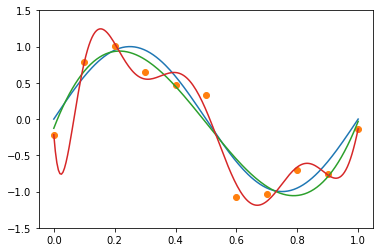

In [6]:
plt.ylim(-1.5, 1.5)

plt.plot(x, np.sin(2*np.pi*x))
plt.plot(x_data, y_data, marker='o', linewidth=0)
plt.plot(x, func_m3(x))
plt.plot(x, func_m9(x))

M=9までになると、かなり過学習（over-fitting）してしまっていることが見て取れる。squared error の定義から、最小化するには、曲線上にデータ点がくることが望ましいために起きてしまっている問題である。
過学習してしまった場合、この訓練データをうまく記述できるかもしれないが、未知の新しいデータセットに対しては汎化性能を持たないことも予想される。

0〜9次までのフィットがどうなっているかを次にまとめる：

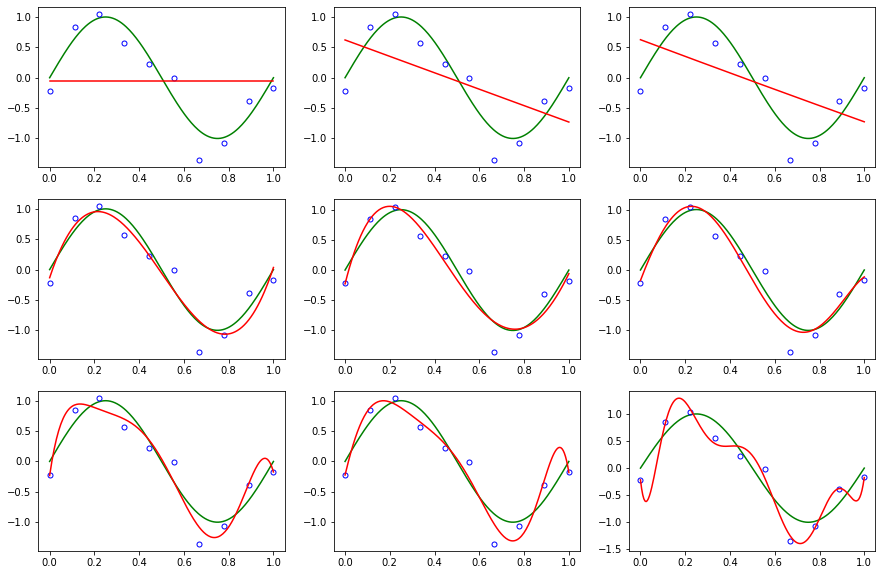

In [32]:
# 訓練データ
np.random.seed(123)
x_data = np.linspace(0, 1, 10)
noise = np.random.randn(10)/5
y_data = np.sin(2*np.pi*x_data) + noise

fig, axis = plt.subplots(3,3, figsize=(15,10))

M = 0 
for row in axis :
    for col in row :
        func = np.poly1d(np.polyfit(x_data, y_data, M))
        col.plot(x, np.sin(2*np.pi*x), color="green")
        col.plot(x_data, y_data, marker='o', linewidth=0, color='none', markersize=5, markeredgewidth=1, markeredgecolor='blue')
        col.plot(x, func(x), color="red")
        M += 1

一般的な目標は、訓練データを用いて作成したモデルを使って、新しいデータ（テストデータ）を予測することである。このときに Root mean square error (RMS error)を考えると便利がことが多い。RMSは定義した残差の関数 $E(\hat{w})$を使って次のように定義される（ここで $\hat{w}$は訓練データフィット後の最適化された（はずの）パラメータを用いて表されたモデルを使用しているもの）：

$$
E_{RMS} = \sqrt{2E(\hat{w})/N}
$$

Nで割ることで、テストデータのサンプル数に依存しない指標とすることができ、また平方根を取ることでデータと同じ次元をもたせることができる。このRMSエラーをて訓練データ・テストデータに対して計算して比較する。

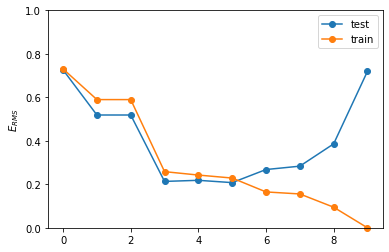

In [85]:
# 訓練データ
np.random.seed(123)
x_train = np.linspace(0, 1, 10)
noise = np.random.randn(10)/5
y_train = np.sin(2*np.pi*x_train) + noise

# テストデータ
np.random.seed(456)
x_test = np.linspace(0, 1, 100)
noise = np.random.randn(100)/5
y_test = np.sin(2*np.pi*x_test) + noise


## 訓練データを用いたフィッティング
func_list = []
for M in range(0, 10):
    func = np.poly1d(np.polyfit(x_train, y_train, M))
    func_list.append(func)
    
# RMS の計算
rms_error_train = []
rms_error_test = []
for func in func_list : 
    y_pred_train = func(x_train)
    y_pred_test = func(x_test)

    rms_error_train.append(np.sqrt( 2 * 0.5* np.sum( ( y_pred_train - y_train ) **2 ) / 10 ))
    rms_error_test.append(np.sqrt( 2 * 0.5 * np.sum( ( y_pred_test - y_test ) **2 ) / 100 ))
    
plt.plot(rms_error_test, label="test", marker='o', clip_on=False)
plt.plot(rms_error_train, label="train", marker='o', clip_on=False)
plt.ylabel("$E_{RMS}$")
plt.legend(loc="best")
plt.ylim(0, 1)

plt.show()

フィットした後の最適化された係数を表示してみる。次数が大きくなるほど、係数が発散気味になっていることが見て取れる。これは、モデルがランダムノイズに引っ張られて、過適合してしまっていると考えられる。係数が大きくなることは”悪”であるため、それを抑えるために正則化と呼ばれる手法も存在する。

In [109]:
coef_dict = {}
for func in func_list : 
    tmp_list = []
    for idx, w_coef in enumerate(func):
        tmp_list.append(round(w_coef, 3)) 
    
    
    coef_dict["M={}".format(len(func))] = tmp_list

df_coef = pd.DataFrame.from_dict(coef_dict, orient="index").T
df_coef

,M=0,M=1,M=2,M=3,M=4,M=5,M=6,M=7,M=8,M=9
0,-0.054,-1.351,0.029,21.986,-14.327,-53.817,-475.293,-824.319,11149.117,70528.824
1,NaN,0.622,-1.380,-32.951,50.640,120.217,1372.063,2409.822,-45420.787,-306230.591
2,NaN,NaN,0.626,11.133,-50.815,-66.740,-1482.765,-2603.534,75250.721,554458.361
3,NaN,NaN,NaN,-0.134,14.671,-9.289,762.757,1243.436,-65038.589,-543220.993
4,NaN,NaN,NaN,NaN,-0.228,9.689,-202.012,-201.396,31232.840,312668.028
5,NaN,NaN,NaN,NaN,NaN,-0.174,25.310,-39.426,-8150.990,-107407.073
6,NaN,NaN,NaN,NaN,NaN,NaN,-0.232,15.457,1014.536,21360.259
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.223,-36.806,-2261.809
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.216,105.038
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.217


ただし、データ点が十分に利用できるのであれば問題は解消される！データ集合を大きくするほど、より複雑で柔軟なモデルをデータに当てはめることができるようになるのである。

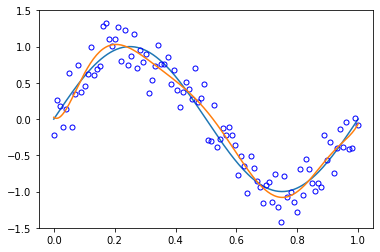

In [79]:
# 訓練データ
np.random.seed(123)
x_data = np.linspace(0, 1, 100)
noise = np.random.randn(100)/5
y_data = np.sin(2*np.pi*x_data) + noise

func_m9 = np.poly1d(np.polyfit(x_data, y_data, 9))

plt.ylim(-1.5, 1.5)

plt.plot(x, np.sin(2*np.pi*x))
plt.plot(x_data, y_data, marker='o', linewidth=0, color='none', markersize=5, markeredgewidth=1, markeredgecolor='blue')
plt.plot(x, func_m9(x))